In [19]:
from IPython.display import HTML
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")

# Relax Challenge

In [2]:
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [1]:
import pandas as pd
import numpy as np
import scipy.stats

import statsmodels.api as sm
import json
import time
import pylab
from scipy import stats
from datetime import date
import datetime as dt

import plotly
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

from IPython.display import display, Math, Latex

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

The data is available as two attached CSV files:

    takehome_user_engagement.csv
    takehome_users.csv


# The data has the following two tables:


**1.  User table **
----
- ( "takehome_users" ) with data on 12,000 users who signed up for the product in the last two years. 

This table includes:

    ● name: the user's name

    ● object_id: the user's id

    ● email: email address

    ● creation_source: how their account was created. 

This takes on one of 5 values:

PERSONAL_PROJECTS: invited to join another user's
personal workspace
- GUEST_INVITE: invited to an organization as a guest
(limited permissions)
- ORG_INVITE: invited to an organization (as a full member)
- SIGNUP: signed up via the website
- SIGNUP_GOOGLE_AUTH: signed up using Google
Authentication (using a Google email account for their login id)

    a. creation_time: when they created their account

    b. last_session_creation_time: unix timestamp of last login

    c. opted_in_to_mailing_list: whether they have opted into receiving marketing emails

    d. enabled_for_marketing_drip: whether they are on the regular marketing email drip

    e. org_id: the organization (group of users) they belong to

    f. invited_by_user_id: which user invited them to join (if applicable).

In [20]:
takehome_users = pd.read_csv('takehome_users.csv',encoding='ISO-8859-1')
takehome_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,4/22/2014 3:53,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,11/15/2013 3:45,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,3/19/2013 23:14,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,5/21/2013 8:09,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,1/17/2013 10:14,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [21]:
takehome_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


# **2. Usage summary table **
- ( "takehome_user_engagement" ) that has a row for each day that a user logged into the product.

In [22]:
takehome_user_engagement=pd.read_csv('takehome_user_engagement.csv')
takehome_user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [23]:
takehome_user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


Project 
----
Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one seven day period, identify which factors predict future user
adoption.

We suggest spending 1-2 hours on this, but you're welcome to spend more or less.

1. Please send us a brief write-up of your findings (the more concise, the better no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. 

2. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.

**Thoughts:**

**takehome_users: **

*Need to make sure the date/time variables are coded as such. One of the column titles is inconsistent with the data description. Certainly not all of the data is going to be useful, certainly not the personal details of the users.*

**takehome_user_engagement:** 

*The time stamp is going to need to be changed*

    a. I'm already thinking that the data are going to need to be merged between the user_engagement dataset and the user dataset.
    b. Since the question mentioned seven day units I will need to code weekly units.

**Data Cleaning/Prep**

In [24]:
#Functions I commonly use to deal with date/time values
def get_date_int(df, column):
    '''
    This handy function parses year,month,week,day.
    '''
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

def get_week(x): return x.isocalendar()

def get_iso_date_int(df,column):
    '''
    With time coded as iso (year,week,day) this seperates those time periods.
    '''
    temp_df=pd.DataFrame(df[column].tolist(), index=df.index)
    year,week,day=temp_df[0],temp_df[1],temp_df[2]
    return year,week,day

In [25]:
takehome_users = pd.read_csv('takehome_users.csv',encoding='ISO-8859-1')
#code creation_time,last_session_time as date/time
takehome_users.creation_time = pd.to_datetime(takehome_users['creation_time'])
takehome_users.last_session_creation_time = pd.to_datetime(takehome_users['last_session_creation_time'])
#change column heading
takehome_users['user_id'] = takehome_users['object_id']
#drop original column
takehome_users.drop('object_id', axis=1, inplace=True)
#drop private information
takehome_users.drop(['name', 'email'], axis=1, inplace=True)

takehome_users.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id
0,2014-04-22 03:53:00,GUEST_INVITE,1970-01-01 00:00:01.398138810,1,0,11,10803.0,1
1,2013-11-15 03:45:00,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316.0,2
2,2013-03-19 23:14:00,ORG_INVITE,1970-01-01 00:00:01.363734892,0,0,94,1525.0,3
3,2013-05-21 08:09:00,GUEST_INVITE,1970-01-01 00:00:01.369210168,0,0,1,5151.0,4
4,2013-01-17 10:14:00,GUEST_INVITE,1970-01-01 00:00:01.358849660,0,0,193,5240.0,5


In [26]:
takehome_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 8 columns):
creation_time                 12000 non-null datetime64[ns]
creation_source               12000 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
user_id                       12000 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(4), object(1)
memory usage: 750.1+ KB


In [27]:
#make user engagement time_stamp into date/time
takehome_user_engagement['time_stamp'] = pd.to_datetime(takehome_user_engagement['time_stamp'])
#Make a weekly unit for time stamp
takehome_user_engagement['week_time_stamp']=takehome_user_engagement['time_stamp'].apply(get_week)

In [28]:
#This is useful to know so we know where the start and finish of the trial exists
print('First user engagement timestamp:',min(takehome_user_engagement.time_stamp))
print('Last user engagement timestamp:',max(takehome_user_engagement.time_stamp))

First user engagement timestamp: 2012-05-31 08:20:06
Last user engagement timestamp: 2014-06-06 14:58:50


In [29]:
#Create Year,Month,Week,and Day units. To be fair I would be doing this regardless of use,
# since I know I will be working with time its useful to have options for working with the data
year, month, day=get_date_int(takehome_user_engagement, 'time_stamp')
takehome_user_engagement['year'],takehome_user_engagement['month'],takehome_user_engagement['day']=year,month,day
takehome_user_engagement['week']=takehome_user_engagement['time_stamp'].dt.week
#Make year and week, So if we are dealing with 52 week units then I want year to make it individual unit of time
iso_year,iso_week,iso_day=get_iso_date_int(takehome_user_engagement,'week_time_stamp')
takehome_user_engagement['year_week']=list(zip(iso_year,iso_week))

Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one seven day period, identify which factors predict future user
adoption.

    a. After playing with the data and thinking about the problem I decided the easiest time scale to use is the year/week units I created. I minimized the data to values I will need to solve the problem of 'adopted users'.

In [30]:
takehome_user_engagement=takehome_user_engagement.sort_values(['time_stamp','user_id'],ascending=True)
takehome_user_engagement=takehome_user_engagement[['user_id','visited','day','year_week']]

In [31]:
#I tried to do this without using any for loops.... 
#   - I still think I can but for parsimony I decided just to use a single for loop
# What I got is a label dictionary for user_id and adopted_engagement_index which,
# I define as the number of logins of user attempts in a week that are,
#    - seperate daily events (greater than 3 days).

# Label dictionary
adopted_user_dict={}
#number of year/week units
weeks=takehome_user_engagement.year_week
#individual user ids
user_ids=list(set(takehome_user_engagement['user_id']))
#loop over user ids
for i in range(len(user_ids)):
    user_id=user_ids[i]
    #dataframe for specific user that has duplicate records by week
    reduced_df=takehome_user_engagement[(takehome_user_engagement['user_id']==user_id)&(weeks.isin(weeks[weeks.duplicated()]))]
    #count the number of duplicate 'day' records of weeks if greater than 2 keep
    week_counts=reduced_df.year_week.value_counts()[reduced_df.year_week.value_counts()>2]
    three_logins=reduced_df[reduced_df.year_week.isin(list(week_counts.index))]
    #remove duplicates of 3 day events within week
    three_logins=three_logins[~three_logins.duplicated()]
    #code user id and number of 3 day events
    adopted_user_dict[str(user_id)]=len(three_logins)

In [32]:
#apply the label dictionary to user ids coded to the column (engagement_index)
takehome_user_engagement['engagement_index']=takehome_user_engagement['user_id'].apply(lambda x: adopted_user_dict[str(x)])
#Code engagement_index as boolean values, which will be the adopted_user records
takehome_user_engagement['adopted_user']=0
takehome_user_engagement['adopted_user'][takehome_user_engagement['engagement_index']>0]=1

*After coding for 'adopted_users' I am left with 1445 users who have logged in on 3 seperate days within a seven day period.*

In [33]:
adopted_count=takehome_user_engagement[['user_id','adopted_user']][takehome_user_engagement['adopted_user']==1].groupby('user_id').count()
print('Number of adopted users:',len(adopted_count))

Number of adopted users: 1445


In [34]:
#Narrow down the dataset for merging
adopted=takehome_user_engagement[['user_id','adopted_user']]
#Merge the adopted user info to users dataframe
adopted_users = pd.merge(takehome_users, adopted, on='user_id', how='outer')

*After merging the 'adopted_users' to the larger 'users' dataset I will modify the time units to useful units, once again I am not certain which time units I will need but is a thing I typically do so I have options for different scales of time.*

In [35]:
creation_year, creation_month, creation_day=get_date_int(adopted_users, 'creation_time')
last_session_year, last_session_month, last_session_day=get_date_int(adopted_users, 'last_session_creation_time')
adopted_users['creation_year'],adopted_users['creation_month'],adopted_users['creation_day']=creation_year, creation_month, creation_day
adopted_users['last_session_year'],adopted_users['last_session_month'],adopted_users['last_session_day']=last_session_year, last_session_month, last_session_day
adopted_users.drop(['creation_time', 'last_session_creation_time', 'user_id'], axis=1, inplace=True)

#### Model Prep

*Fill in the missing values with something (zero) I think if I had more time I would spend it looking at what would be the best imputation method (mode,median,mean, or zero fill)*

In [36]:
adopted_users.last_session_day.fillna(0, inplace=True)
adopted_users.last_session_month.fillna(0, inplace=True)
adopted_users.last_session_year.fillna(0, inplace=True)

*Label encoder for the string values*

In [37]:
from sklearn import preprocessing 
from sklearn.preprocessing import LabelEncoder
le = preprocessing.LabelEncoder()
adopted_users['creation_source']=le.fit_transform(adopted_users['creation_source'])

*Create binary for the invited users *

In [38]:
adopted_users['invited'] = np.where(adopted_users['invited_by_user_id'].isnull(), 1, 0)
adopted_users.drop('invited_by_user_id', axis=1, inplace=True)
#Fill in the missings
adopted_users=adopted_users.fillna(0)
#Create column labels for output
col_names=list(pd.Series(adopted_users.columns)[pd.Series(adopted_users.columns)!='adopted_user'])
#Code as arrays
X=adopted_users[list(pd.Series(adopted_users.columns)[pd.Series(adopted_users.columns)!='adopted_user'])].values
y=adopted_users['adopted_user'].values

Train/Test Split

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state=3)
print('Train size:',(len(X_train)/len(X))*100)
print('Train observations:',(len(X_train)))
print('Test size:',(len(X_test)/len(X))*100)
print('Test observations:',(len(X_test)))


Train size: 69.99962102191441
Train observations: 147765
Test size: 30.00037897808559
Test observations: 63329


 Fit Random Forest Model
 ------

Accuracy: 0.9999187899705614 

Feature ranking:


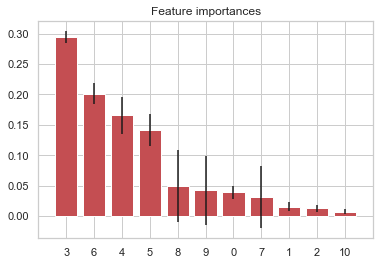

,features,importance
3,org_id,0.294753
6,creation_day,0.201543
4,creation_year,0.165988
5,creation_month,0.141612
8,last_session_month,0.049464
9,last_session_day,0.042067
0,creation_source,0.038696
7,last_session_year,0.030629
1,opted_in_to_mailing_list,0.015522
2,enabled_for_marketing_drip,0.012688


In [46]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=20,random_state=0,criterion='gini', class_weight='balanced')

clf.fit(X_train, y_train.ravel())
Accuracy=clf.score(X_train, y_train.ravel())
print('Accuracy:',Accuracy,'\n')

importFeature = clf.feature_importances_
feature_importances=pd.DataFrame([importFeature])

std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
indices = np.argsort(importFeature)[::-1]

# Print the feature ranking
print("Feature ranking:")

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importFeature[indices],color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

feature_importances=pd.DataFrame(pd.Series(col_names)[indices])
feature_importances['importance']=np.sort(importFeature)[::-1]
feature_importances.columns=['features','importance']
feature_importances

**Explanation:**

Although I got an accuracy of 99% I believe the model is falacious to a degree since it is seperating the data too well, either because the model is overfitting, or because the data is improperly prepared. Regardless of the reasoning we can see the most important features for predicting the 'Adopted Users' in the dataset to be the group of users assigned the organization id (org_id), the time the id was created, and the last login time. This means that users from particular cohorts are more likely to login more frequently than others for som unspecified reason. I think the data needs more features that describe user details in order to get a proper model for describing user adoption.